# Realtor.com Dataset:

## Business Case:

TODO: In your own words, give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why and how was this data collected in the first place?). What is the prediction task for your data and why are other third parties interested in the result? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to these third parties?


### Importing Relevant Libraries:

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [18]:
df = pd.read_csv("realtor-data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923159 entries, 0 to 923158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        923159 non-null  object 
 1   price         923088 non-null  float64
 2   bed           791456 non-null  float64
 3   bath          807967 non-null  float64
 4   acre_lot      649536 non-null  float64
 5   full_address  923159 non-null  object 
 6   street        921021 non-null  object 
 7   city          923085 non-null  object 
 8   state         923159 non-null  object 
 9   zip_code      922954 non-null  float64
 10  house_size    625316 non-null  float64
 11  sold_date     456396 non-null  object 
dtypes: float64(6), object(6)
memory usage: 84.5+ MB


## Understanding the data:

In [19]:
df.head(10)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,for_sale,179000.0,4.0,3.0,0.46,"Bo Calabazas San Sebastian, San Sebastian, PR,...",Bo Calabazas San Sebastian,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,for_sale,50000.0,3.0,1.0,0.20,"49.1 140, Ciales, PR, 00639",49.1 140,Ciales,Puerto Rico,639.0,2040.0,NaN
7,for_sale,71600.0,3.0,2.0,0.08,"3467 St, Ponce, PR, 00731",3467 St,Ponce,Puerto Rico,731.0,1050.0,NaN
8,for_sale,100000.0,2.0,1.0,0.09,"230 Rio De Vida, Ponce, PR, 00730",230 Rio De Vida,Ponce,Puerto Rico,730.0,1092.0,NaN
9,for_sale,300000.0,5.0,3.0,7.46,"Pr 120 Bo Maravilla Sur K M # 335, Las Marias,...",Pr 120 Bo Maravilla Sur K M # 335,Las Marias,Puerto Rico,670.0,5403.0,NaN


TODO For each of the following:

appropriately define data types. What data type should be used to represent each data attribute? Discuss the attributes collected in the dataset. For datasets with a large number of attributes, only discuss a subset of relevant attributes.

Verify data quality: Explain any missing values or duplicate data. Visualize entries that are missing/complete for different attributes. Are those mistakes? Why do these quality issues exist in the data? How do you deal with these problems? Give justifications for your methods (elimination or imputation).


### status: Saaketh

The status feature tells whether the given listing was for_sale or ready_to_build. This feature should be one-hot encoded. Because there are only two values for status, we will only the ready_to_build column. After the transformation, the status column will be replaced with a read_to_build column. There are no missing values.

In [20]:
df.status.value_counts()

for_sale          921528
ready_to_build      1631
Name: status, dtype: int64

Only 1,631 out of the 923,159 listings were labeled as ready_to_build

In [21]:
df["ready_to_build"] = pd.get_dummies(df.status).ready_to_build

In [22]:
df.drop(columns=["status"], inplace=True)

### price: Ray

#The bed column gives a count of the number of bedrooms in a given property, the value is an integer but is stored as a float in pandas, I have a suspicion that this means there are some missing values

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923159 entries, 0 to 923158
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           923088 non-null  float64
 1   bed             791456 non-null  float64
 2   bath            807967 non-null  float64
 3   acre_lot        649536 non-null  float64
 4   full_address    923159 non-null  object 
 5   street          921021 non-null  object 
 6   city            923085 non-null  object 
 7   state           923159 non-null  object 
 8   zip_code        922954 non-null  float64
 9   house_size      625316 non-null  float64
 10  sold_date       456396 non-null  object 
 11  ready_to_build  923159 non-null  uint8  
dtypes: float64(6), object(5), uint8(1)
memory usage: 78.4+ MB


### bed: Vedant
From this visual, it seems that the missing values of bed are also highly indicative of missing values in bath(# bathrooms), house size and sold date. That honestly doesn't give me much confidence that imputation would actually work super well with this dataset but lets try it anyway and see if the distibution is relatively similar.

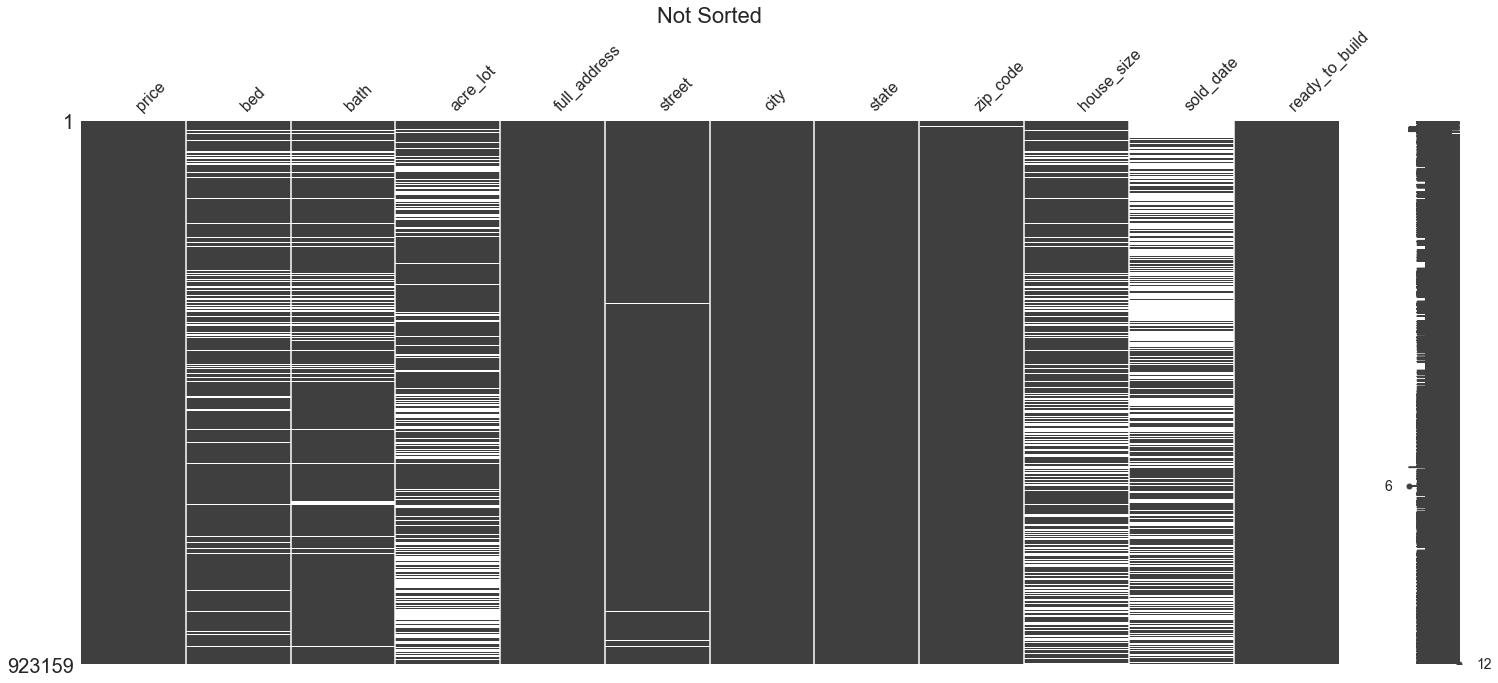

<Figure size 432x288 with 0 Axes>

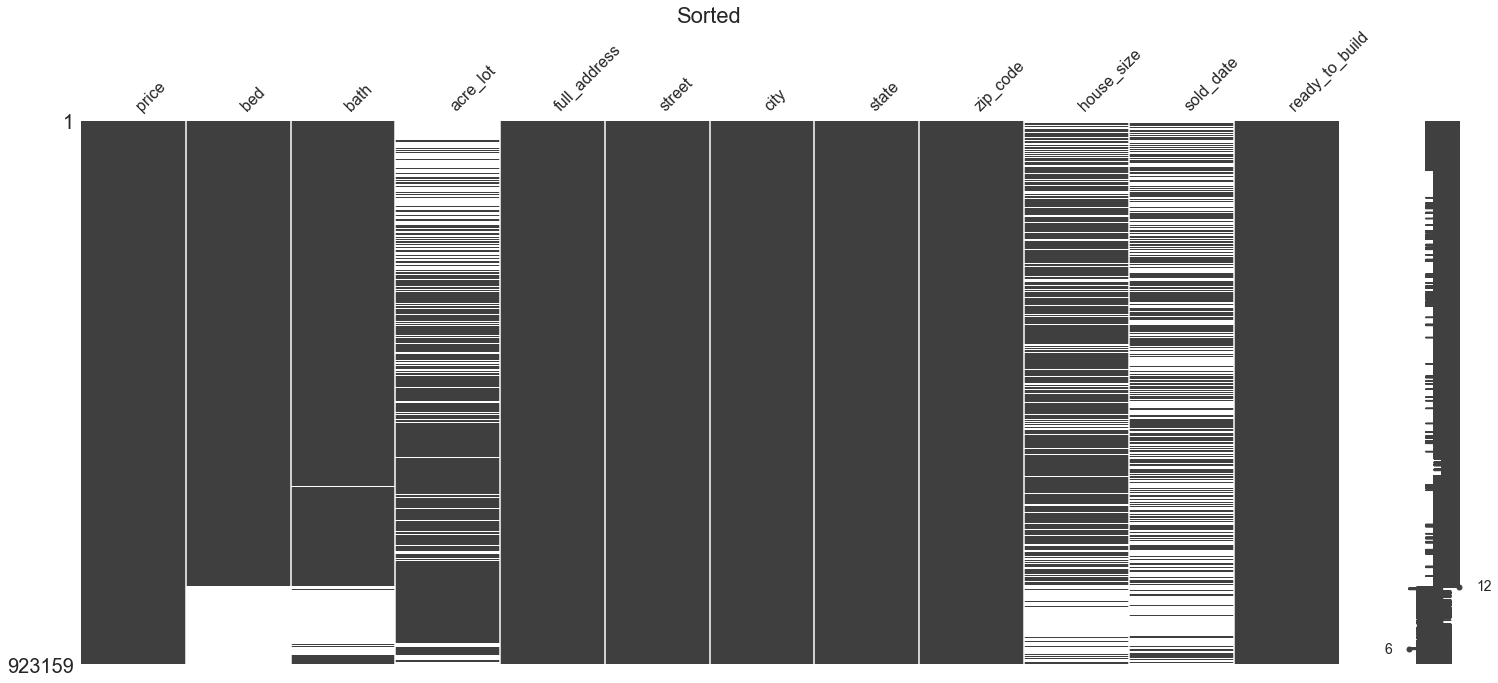

In [24]:
#As suspected, we have a lot of missing values, over 12000, but this is only about 13% of our dataset so let's try imputation and see if we can get some decent results.
# this python magics will allow plot to be embedded into the notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# External package: conda install missingno
import missingno as mn

mn.matrix(df)
plt.title("Not Sorted",fontsize=22)

plt.figure()
mn.matrix(df.sort_values(by=["bed"]))
plt.title("Sorted",fontsize=22)
plt.show()

From this visual, it seems that the missing values of bed are also highly indicative of missing values in bath(# bathrooms), house size and sold date. That honestly doesn't give me much confidence that imputation would actually work super well with this dataset but lets try it anyway and see if the distibution is relatively similar.

In [25]:
df.info()

#From this visual, it seems that the missing values of bed are also highly indicative of missing values in bath(# bathrooms), house size and sold date. That honestly doesn't give me much confidence that imputation would actually work super well with this dataset but lets try it anyway and see if the distibution is relatively similar.

In [26]:
#As suspected, we have a lot of missing values, over 12000, but this is only about 13% of our dataset so let's try imputation and see if we can get some decent results.
# this python magics will allow plot to be embedded into the notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# External package: conda install missingno
import missingno as mn

mn.matrix(df)
plt.title("Not Sorted",fontsize=22)

plt.figure()
mn.matrix(df.sort_values(by=["bed"]))
plt.title("Sorted",fontsize=22)
plt.show()

#From this visual, it seems that the missing values of bed are also highly indicative of missing values in bath(# bathrooms), house size and sold date. That honestly doesn't give me much confidence that imputation would actually work super well with this dataset but lets try it anyway and see if the distibution is relatively similar.

### bath: Saaketh


### acre_lot: Ray

### full_address: Vedant

### street: Saaketh


In [27]:
df.street.isna().sum()

(601.0, 99999.0)

### city: Ray

### state: Vedant

### zip_code: Saaketh

In the US, a Zip Code is 5 digits. Any entries in the zip code feature that have less than 5 digits have leading 0s in their official zipcode.

In [28]:
df.zip_code.min(), df.zip_code.max()

SyntaxError: invalid syntax (<ipython-input-28-2cf06e47ada9>, line 1)

In [ ]:
df.zip_code.isna().sum(), (df.zip_code.isna().sum()*100)/len(df)

There are only 205 NaN values for the zip_code feature. These account for ~0.02% of the dataset. For this reason, we will eliminate the NaN values. If we had more NaN values, we could impute by taking the mode zipcode grouped by city. This is using the logic that a single zipcode covers most of the city.

In [ ]:
df.dropna(subset=["zip_code"], inplace=True)

TODO if bored: Encode this

### house_size: Ray

### sold_date: Vedant

## Data Visualization:


TODO: Ask three interesting questions that are relevant to your dataset and explore visuals that help answer these questions. Use whichever visualization method is appropriate for your data
Visualize basic feature distributions. That is, plot the dynamic range and exploratory distribution plots (like boxplots, histograms, kernel density estimation) to better understand the data. Describe anything meaningful or potentially useful you discover from these visualizations. These may also help to understand what data is missing or needs imputation. Note: You can also use data from other sources to bolster visualizations. Visualize at least five plots, at least one categorical.


We will each do 2 plots

Question ideas:


How do house prices vary by location?
How do house prices vary by size / features of the house?
How have house prices changed over time?
How have house features changed over time? (ie have bedrooms / bathrooms increased in number, sqft increased or decreased, ect.)

### How do house prices vary by location? Saaketh

### Question 2: Ray

### Question 3: Vedant